In [1]:
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd
import folium, h3, json
from shapely.geometry import Polygon, Point
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from folium.plugins import Fullscreen

In [2]:
# Import the dataset
df_final = pd.read_csv('features_hex_7.csv')

# load the spatial feature map as a geodataframe
spatial_features = gpd.read_file('spatial_features_hex7.geojson', crs='epsg:4326')

# Load the weather dataset
weather = pd.read_csv('Weather_chic.csv')

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Define helper functions
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [3]:
def perform_svr_grid_search(X_train: pd.DataFrame, y_train: pd.Series, use_rbf_kernel: bool = False) -> GridSearchCV:
    """
    Perform grid search to tune the hyperparameters of an SVR model using cross-validation.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target values.
    - use_rbf_kernel (bool): If True, include gamma in the parameter grid for RBF kernel.

    Returns:
    - GridSearchCV: The fitted GridSearchCV object with the best parameters.
    """
    
    # Define the base parameter grid for SVR hyperparameters
    param_grid = {
        'svr__C': [0.1, 1, 10, 100],
        'svr__epsilon': [0.1, 0.5, 1, 5],
        'svr__kernel': ['linear', 'rbf', 'poly']
    }
    
    # Add gamma to the parameter grid if RBF kernel is specified
    if use_rbf_kernel:
        param_grid['svr__gamma'] = [0.0001, 0.0002, 0.005]

    # Create a pipeline that first scales the data then applies SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Data scaling step
        ('svr', SVR())                 # SVR model step
    ])

    # Set up GridSearchCV with cross-validation and parallel processing
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        refit=True,     # Refit the model with the best parameters
        verbose=1,      # Print detailed progress
        n_jobs=-1,      # Use all available processors
        cv=3            # Number of cross-validation folds
    )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters found
    print(f"Optimal Parameters: {grid_search.best_params_}")
    
    return grid_search


In [4]:
def train_svm_kernel(X_train, y_train, X_test, kernel_type: str, C=1, epsilon=0.1, degree=3, gamma='scale'):
    """
    Train an SVM model with a specified kernel and evaluate its performance.

    Parameters:
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_test: Testing feature data.
    - kernel_type (str): The type of kernel to use ('poly', 'linear', 'rbf', 'sigmoid').
    - C (float): Regularization parameter. Default is 1.
    - epsilon (float): Epsilon in the epsilon-SVR model. Default is 0.1.
    - degree (int): Degree of the polynomial kernel function ('poly'). Ignored by other kernels. Default is 3.
    - gamma (str): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Default is 'scale'.

    Returns:
    - svr_model: The trained SVM model.
    - scaler: The scaler used to standardize the training and testing data.
    """
    
    # Validate the kernel type
    if kernel_type not in ['poly', 'linear', 'rbf', 'sigmoid']:
        raise ValueError("kernel_type must be one of 'poly', 'linear', 'rbf', or 'sigmoid'")
    
    # Standardize the training and testing data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize the SVR model based on the kernel type
    if kernel_type in ['linear', 'sigmoid']:
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon)
    elif kernel_type == 'poly':
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon, degree=degree)
    elif kernel_type == 'rbf':
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon, gamma=gamma)

    # Train the SVM model
    svr_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_pred = svr_model.predict(X_test_scaled)

    # Evaluate the model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation results
    print(f'RESULTS of {kernel_type}-kernel:\n-----------------------------------------')
    print("Mean Absolute Error (MAE):       ", round(mae, 2))
    print("Mean Squared Error (MSE):        ", round(mse, 2))
    print("Root Mean Squared Error (RMSE):  ", round(rmse, 2))
    print("R-squared (R²):                  ", round(r2, 4))
    print('-----------------------------------------')

    # Return the trained model and the scaler
    return svr_model, scaler

In [5]:
def stacked_svm_predict(X_test, meta_model, *kernel_models):
    """
    Make predictions using pre-trained SVM kernels and a pre-trained meta-model.

    Parameters:
    - X_test: Test features for which predictions are required.
    - meta_model: The pre-trained meta-model that will combine the kernel predictions.
    - kernel_models: A variable number of tuples where each tuple contains:
        - A list of feature names corresponding to the kernel.
        - The pre-fitted scaler for those features.
        - The pre-trained SVM model.

    Returns:
    - predictions_df: A DataFrame containing predictions from each kernel and the final stacked model.
    """

    # List to hold predictions from each kernel for the testing data
    test_predictions = []

    # Iterate over each provided SVM kernel, its corresponding features, and scaler
    for features, scaler, svm_model in kernel_models:
        # Scale the relevant features for the current kernel using the provided scaler
        X_test_scaled = scaler.transform(X_test[features])

        # Predict using the trained kernel on the scaled testing data
        test_pred = svm_model.predict(X_test_scaled)

        # Store the predictions
        test_predictions.append(test_pred)

    # Stack the predictions from all kernels as input to the meta-model
    X_meta_test = np.column_stack(test_predictions)

    # Make final predictions using the meta-model on the test data
    y_final_pred = meta_model.predict(X_meta_test)

    # Create a DataFrame to store all predictions
    predictions_df = pd.DataFrame({
        'Meta_Prediction': y_final_pred
    })

    # Add each kernel's prediction to the DataFrame
    for i, (features, scaler, svm_model) in enumerate(kernel_models):
        predictions_df[f'Kernel_{i+1}_Prediction'] = test_predictions[i]

    return predictions_df

In [6]:
def create_prediction_map(selected_hour: int, prediction_data: pd.DataFrame):
    """
    Create a folium map that visualizes predictions for a specific hour.

    Parameters:
    - selected_hour (int): The hour of the day for which predictions should be displayed (0-23).
    - prediction_data (pd.DataFrame): The DataFrame containing prediction data, geometry, and other relevant features.

    Returns:
    - folium.Map: A Folium map object with predictions visualized for the selected hour.
    """
    
    # Validate the hour input to ensure it is between 0 and 23
    if selected_hour not in range(24):
        raise ValueError('selected_hour must be between 0 and 23')
        
    # Filter the prediction data for the specified hour
    hourly_data = prediction_data[prediction_data['hour'] == selected_hour].copy()
    
    # Create a log column for the colormap
    shift = abs(hourly_data['Meta_Prediction'].min()) + 1
    hourly_data['Meta_Prediction_Log'] = np.log1p(hourly_data['Meta_Prediction'] + shift)

    # Create a Folium map to explore predictions for the selected hour
    map_object = hourly_data.explore(
        column='Meta_Prediction_Log',  # Column to base the color on
        cmap='Reds',               # Color map for predictions
        legend=True,               # Display a legend on the map
        style_kwds=dict(color="black", weight=1, opacity=0.4, fillOpacity=.9),
        tooltip=['h3_hex_id', 'Meta_Prediction', 'num_hotels'],  # Tooltip columns
        popup=True,                # Enable popups with all columns
    )

    # Add text labels on the map for each prediction
    for _, row in hourly_data.iterrows():
        # Calculate the centroid of the geometry to place the label
        centroid = row['geometry'].centroid
    
        # Add a marker with a label showing the rounded prediction value
        folium.Marker(
            location=[centroid.y, centroid.x],
            icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black">{int(round(row['Meta_Prediction'], 0))}</div>""")
        ).add_to(map_object)

    return map_object

In [7]:
def aggregate_time_bucket(data_frame: pd.DataFrame, time_bucket: int) -> pd.DataFrame:
    
    """
    Aggregates the DataFrame with the features to a certain time bucket.

    Parameters:
    - data_frame (pd.DataFrame): DataFrame containing the features.
    - time_bucket (int): The time bucket to aggregate the features.

    Returns:
    - aggregated_df: Aggregated features for hexagon resolution 7 and specified time bucket.
    """
    
    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = data_frame.copy()
    
    # Convert the time column to the Pandas datetime format
    df_copy['rounded_time'] = pd.to_datetime(df_copy['rounded_time'])
    
    # Round down to the nearest time bucket interval
    df_copy['rounded_time'] = df_copy['rounded_time'].apply(lambda x: x - pd.Timedelta(hours=x.hour % time_bucket))
    
    # Perform the aggregation
    aggregated_df = df_copy.groupby(['rounded_time', 'h3_hex_id']).agg(
        rides=('rides', 'sum'),  
        num_hotels=('num_hotels', 'first'),
        num_bars=('num_bars', 'first'), 
        dist_centre=('dist_centre', 'first'), 
        perc_transport=('perc_transport', 'first'),
        evening_commuting_week=('evening_commuting_week', 'mean'), 
        bar_hours=('bar_hours', 'mean'),
        hour=('rounded_time', 'first'),
        perc_commerc=('perc_commerc', 'first'),
        perc_resid=('perc_resid', 'first'),
        perc_open=('perc_open', 'first'),
        temp=('temp', 'mean')
    ).reset_index()
    
    aggregated_df['hour'] = aggregated_df.hour.dt.hour
    
    # Delete the temporary DataFrame
    del df_copy
    
    return aggregated_df


<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Correlation Heatmap
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

Text(0.5, 1.0, 'Correlation Heatmap')

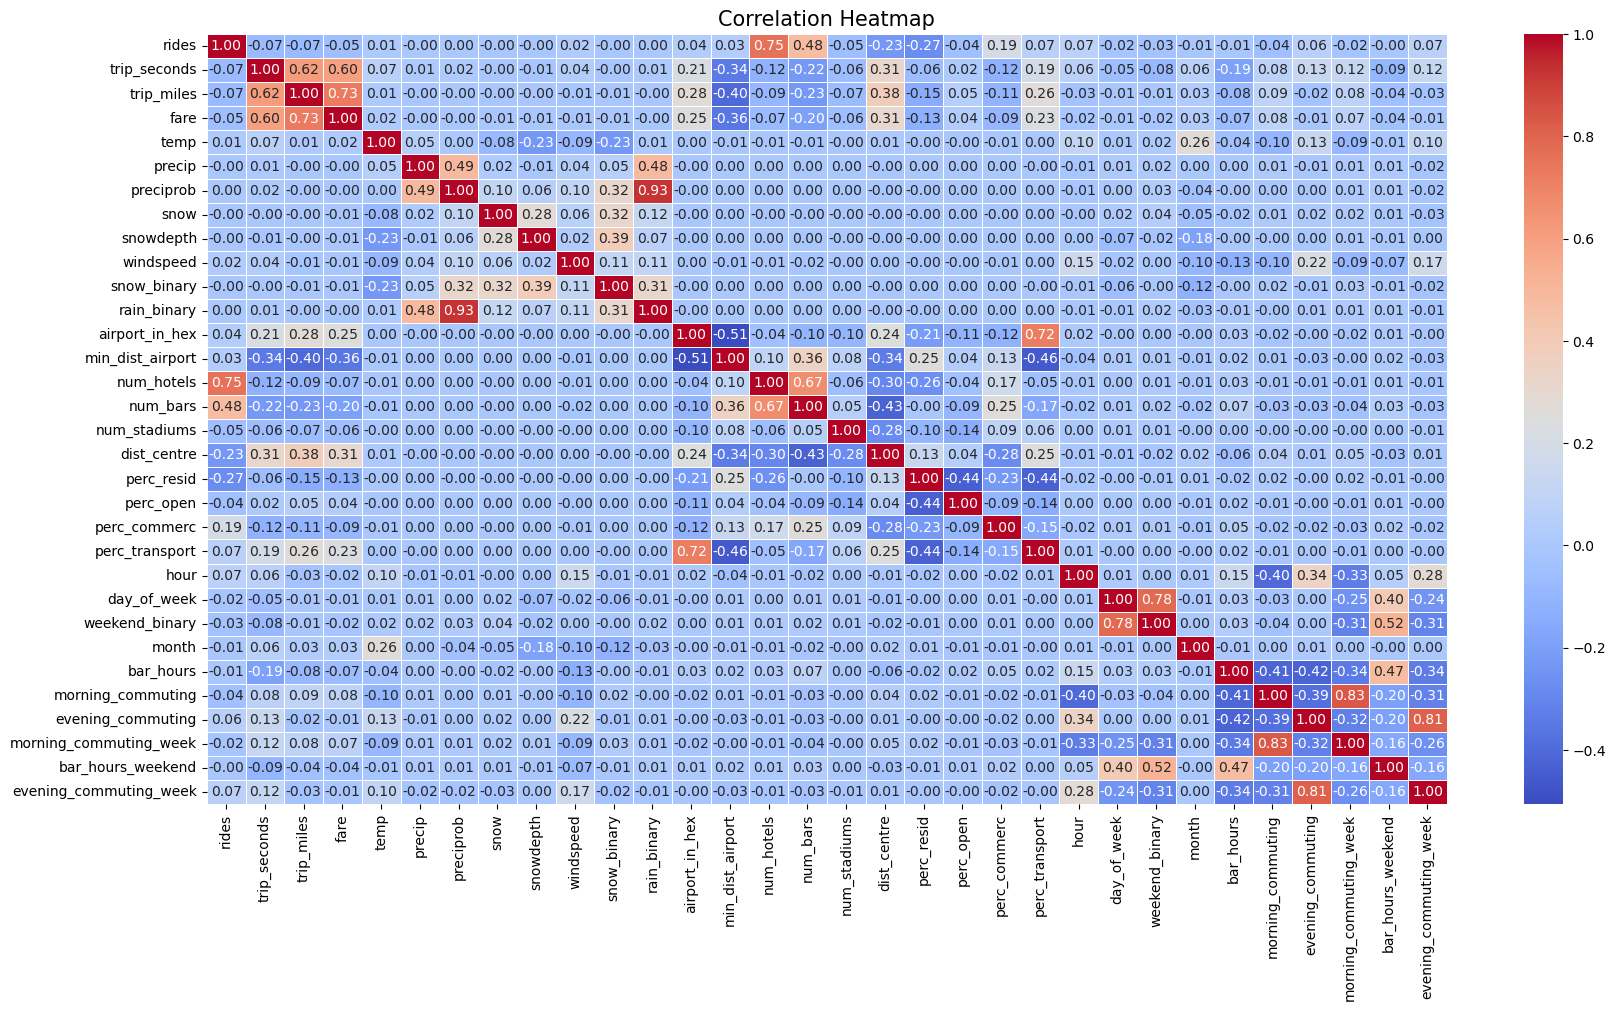

In [8]:
corr_matrix = df_final[['rides','trip_seconds','trip_miles','fare','temp',
                       'precip', 'preciprob', 'snow', 'snowdepth', 'windspeed',
       'snow_binary', 'rain_binary', 'airport_in_hex',
       'min_dist_airport', 'num_hotels', 'num_bars', 'num_stadiums',
       'dist_centre', 'perc_resid', 'perc_open', 'perc_commerc',
       'perc_transport','hour','day_of_week','weekend_binary','month','bar_hours','morning_commuting','evening_commuting'
                       ,'morning_commuting_week','bar_hours_weekend','evening_commuting_week']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Create a heatmap with the correlation matrix, including correlation coefficients
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# Set the title for the heatmap
plt.title('Correlation Heatmap', size=15)

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Support Vector Machines
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 1: Create test train validation split
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">


In [9]:
# Draw a random sample of 10,000 rides from the dataset
df_test = df_final.sample(n=10000, axis=0,random_state=42)

In [10]:
# Split the DataSet into features (X) and dependent variable (Y)

# get the feature vector
independent_variables = ['trip_seconds', 'trip_miles',
       'fare', 'temp', 'precip', 'preciprob', 'snow', 'snowdepth', 'windspeed',
        'snow_binary', 'rain_binary', 
       'min_dist_airport', 'dist_centre', 'num_stadiums', 'num_hotels',
       'num_bars', 'airport_in_hex', 'perc_transport', 'perc_resid',
       'perc_commerc', 'perc_open', 'hour', 'day_of_week', 'month',
       'weekend_binary', 'bar_hours', 'morning_commuting', 'evening_commuting',
       'bar_hours_weekend', 'morning_commuting_week',
       'evening_commuting_week']

# Define the X and Y Variables
X = df_test[independent_variables]
y = df_test['rides']

# First split: train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Second split: train and validation from the train+val set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=12)

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 2: Fit different kernels
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">


In [11]:
# Define the features for poly kernel
features_poly = ['num_hotels', 'num_bars', 'dist_centre', 'perc_transport',
       'evening_commuting_week', 'bar_hours','hour']

# Define the test and train features
X_train_poly = X_train[features_poly]
X_test_poly = X_test[features_poly]

# Fit the model
poly_model,scaler_poly = train_svm_kernel(X_train_poly, y_train,X_test_poly,'poly',C=10,epsilon=5,degree=4)

RESULTS of poly-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        13.55
Mean Squared Error (MSE):         3283.42
Root Mean Squared Error (RMSE):   57.3
R-squared (R²):                   0.7866
-----------------------------------------


In [12]:
perform_svr_grid_search(X_val[features_poly],y_val,use_rbf_kernel=False)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Optimal Parameters: {'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel': 'poly'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [13]:
# Define the features for poly kernel
features_rbf = ['perc_transport','perc_commerc','perc_resid','perc_open','temp']

# Define the test and train features
X_train_rbf = X_train[features_rbf]
X_test_rbf = X_test[features_rbf]

# Fit the model
rbf_model,scaler_rbf = train_svm_kernel(X_train_rbf, y_train,X_test_rbf,'rbf',C=100,epsilon=5, gamma=2)

RESULTS of rbf-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        18.59
Mean Squared Error (MSE):         6730.88
Root Mean Squared Error (RMSE):   82.04
R-squared (R²):                   0.5624
-----------------------------------------


In [14]:
perform_svr_grid_search(X_val[features_rbf],y_val,use_rbf_kernel=True)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Optimal Parameters: {'svr__C': 100, 'svr__epsilon': 5, 'svr__gamma': 0.005, 'svr__kernel': 'rbf'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__gamma': [0.0001, 0.0002, 0.005],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [15]:
# Define the features for poly kernel
features_linear = ['weekend_binary','airport_in_hex','windspeed','snow_binary','min_dist_airport','num_hotels','num_bars','evening_commuting_week',
                  'morning_commuting_week']

# Define the test and train features
X_train_linear = X_train[features_linear]
X_test_linear = X_test[features_linear]

# Fit the model
linear_model,scaler_linear = train_svm_kernel(X_train_linear, y_train,X_test_linear,'linear',C=10,epsilon=5)

RESULTS of linear-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        19.79
Mean Squared Error (MSE):         6777.79
Root Mean Squared Error (RMSE):   82.33
R-squared (R²):                   0.5594
-----------------------------------------


In [16]:
perform_svr_grid_search(X_val[features_linear],y_val,use_rbf_kernel=False)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Optimal Parameters: {'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel': 'linear'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 3: Fit the meta model
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">

In [17]:
# Generate predictions for the training data using the fitted scalers
poly_prediction = poly_model.predict(scaler_poly.transform(X_train[features_poly]))
rbf_prediction = rbf_model.predict(scaler_rbf.transform(X_train[features_rbf]))

# Generate predictions for the test data using the same scalers
poly_prediction_test = poly_model.predict(scaler_poly.transform(X_test[features_poly]))
rbf_prediction_test = rbf_model.predict(scaler_rbf.transform(X_test[features_rbf]))

# Combine predictions to create the meta model training data
X_meta_train = np.column_stack((poly_prediction, rbf_prediction))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta_train, y_train)

# Combine predictions for test data to create the meta model test data
X_meta_test = np.column_stack((poly_prediction_test, rbf_prediction_test))

# Predict using the meta-model
y_pred = meta_model.predict(X_meta_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Output results
print(f'RESULTS:\n-----------------------------------------')
print("Mean Absolute Error (MAE):       ", round(mae, 2))
print("Mean Squared Error (MSE):        ", round(mse, 2))
print("Root Mean Squared Error (RMSE):  ", round(rmse, 2))
print("R-squared (R²):                  ", round(r2, 4))
print('-----------------------------------------')     

RESULTS:
-----------------------------------------
Mean Absolute Error (MAE):        13.66
Mean Squared Error (MSE):         2981.5
Root Mean Squared Error (RMSE):   54.6
R-squared (R²):                   0.8062
-----------------------------------------


<div class="alert alert-danger">
<b>IMPORTANT:</b> This code cell creates a folium map with the prediction results. Unfortunately, the notebook would be too large (for github) to run it directly here. Therefore, we have uploaded the folium as a HTML file to github. This HTML file only shows the prediction for 8am. Alternatively, you can execute the cell and run "map_chicago" in a different cell to display the folium map.
</div>

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 4: Visualize the predictions
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">


In [18]:
# Define the hours of the day (0-23)
hours = list(range(24))

# Define the conditions for morning_commuting, bar_hours, and evening_commuting
morning_commuting = [1 if 5 <= hour <= 10 else 0 for hour in hours]
bar_hours = [0 if 5 <= hour <= 19 else 1 for hour in hours]
evening_commuting = [1 if 13 <= hour <= 18 else 0 for hour in hours]

# Create the DataFrame
time_info = pd.DataFrame({
    'hour': hours,
    'morning_commuting': morning_commuting,
    'bar_hours': bar_hours,
    'evening_commuting_week': evening_commuting
})

weather = pd.read_csv('weather_chic.csv')
spatial_features = gpd.read_file('spatial_features_hex7.geojson')
spatial_features['temp'] = weather['temp'].median()

prediction_map = spatial_features.merge(time_info,how='cross')

data = stacked_svm_predict(
    prediction_map,   # The test features DataFrame
    meta_model,       # The meta-model for stacking
    (features_poly, scaler_poly, poly_model),  # First kernel model
    (features_rbf, scaler_rbf, rbf_model)  # Second kernel model
)

# Concatenate the predictions with the original DataFrame
prediction_map = pd.concat([prediction_map, data], axis=1)

map_chicago = create_prediction_map(8,prediction_map)

fullscreen = Fullscreen(position='topleft')
map_chicago.add_child(fullscreen)

map_chicago.save('predictions_svm_hex7_hourly.html')

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Analyze the results of different temporal resolutions
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 1: Fit the meta models (same features as before) for different time buckets
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">

In [19]:
# Define the time buckets 
time_buckets = [2,4,6,24]

# Create a dict for the results (We already include the results from the hourly model)
results = {
    1: [round(mae,2),round(mse,2),round(rmse,2),round(r2,2)]
}
independent_variables = ['rides', 'num_hotels','num_bars','dist_centre','perc_transport','evening_commuting_week',
                         'bar_hours','hour','perc_commerc','perc_resid','perc_open','temp']

# 
for time in time_buckets:
    
    print(f'Results for {time}-hour interval')
    
    # Get the DataFrame with the features
    df = aggregate_time_bucket(df_final,time)
    
    # Create a random sample from the df
    df = df.sample(n=10000, axis=0,random_state=42)

    # Define the X and Y Variables
    X = df[independent_variables]
    y = df['rides']

    # First split: train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

    # Second split: train and validation from the train+val set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=12)

    # Define the test and train features
    X_train_poly = X_train[features_poly]
    X_test_poly = X_test[features_poly]
    
    # Fit the model
    poly_model,scaler_poly = train_svm_kernel(X_train_poly, y_train,X_test_poly,'poly',C=10,epsilon=5,degree=4)

    # Define the test and train features
    X_train_rbf = X_train[features_rbf]
    X_test_rbf = X_test[features_rbf]

    # Fit the model
    rbf_model,scaler_rbf = train_svm_kernel(X_train_rbf, y_train,X_test_rbf,'rbf',C=100,epsilon=5, gamma=2)
    
    # Generate predictions for the training data using the fitted scalers
    poly_prediction = poly_model.predict(scaler_poly.transform(X_train[features_poly]))
    rbf_prediction = rbf_model.predict(scaler_rbf.transform(X_train[features_rbf]))

    # Generate predictions for the test data using the same scalers
    poly_prediction_test = poly_model.predict(scaler_poly.transform(X_test[features_poly]))
    rbf_prediction_test = rbf_model.predict(scaler_rbf.transform(X_test[features_rbf]))

    # Combine predictions to create the meta model training data
    X_meta_train = np.column_stack((poly_prediction, rbf_prediction))

    # Train the meta-model
    meta_model = LinearRegression()
    meta_model.fit(X_meta_train, y_train)

    # Combine predictions for test data to create the meta model test data
    X_meta_test = np.column_stack((poly_prediction_test, rbf_prediction_test))

    # Predict using the meta-model
    y_pred = meta_model.predict(X_meta_test)

    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Output results
    print(f'RESULTS of meta-model:\n-----------------------------------------')
    print("Mean Absolute Error (MAE):       ", round(mae, 2))
    print("Mean Squared Error (MSE):        ", round(mse, 2))
    print("Root Mean Squared Error (RMSE):  ", round(rmse, 2))
    print("R-squared (R²):                  ", round(r2, 4))
    print('-----------------------------------------')  
    
    results[time] = [round(mae,2),round(mse,2),round(rmse,2),round(r2,2)]

Results for 2-hour interval
RESULTS of poly-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        23.21
Mean Squared Error (MSE):         11260.71
Root Mean Squared Error (RMSE):   106.12
R-squared (R²):                   0.7321
-----------------------------------------
RESULTS of rbf-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        30.24
Mean Squared Error (MSE):         23581.09
Root Mean Squared Error (RMSE):   153.56
R-squared (R²):                   0.4391
-----------------------------------------
RESULTS of meta-model:
-----------------------------------------
Mean Absolute Error (MAE):        23.26
Mean Squared Error (MSE):         9653.95
Root Mean Squared Error (RMSE):   98.25
R-squared (R²):                   0.7704
-----------------------------------------
Results for 4-hour interval
RESULTS of poly-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        37.46
Mean Squared Error (MSE

<span style ="font-size: 16px; font-weight: bold;color: #507F7F;">
        Step 2: Visualize the performance metrics for different time buckets
</span>
<hr style="color: #8EB944; height: 1px;background-color: #507F7F;border: none">


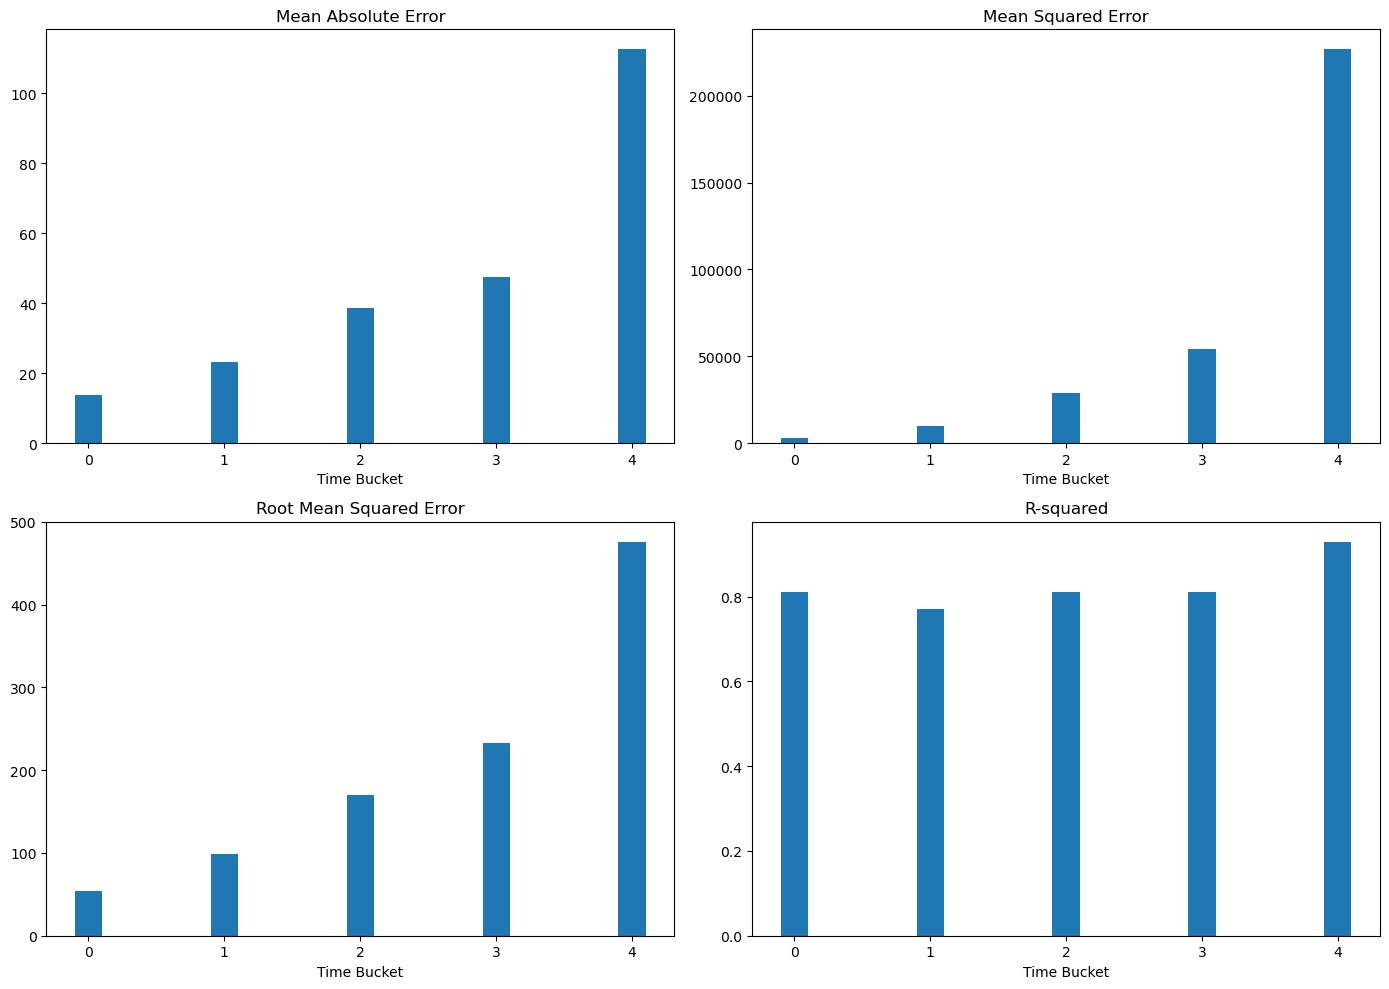

In [20]:
# Convert the dictionary into lists for plotting
keys = list(results.keys())
feature_1 = [results[k][0] for k in keys]
feature_2 = [results[k][1] for k in keys]
feature_3 = [results[k][2] for k in keys]
feature_4 = [results[k][3] for k in keys]

# Convert keys to strings
keys = [str(k) for k in keys]

# Bar width
bar_width = 0.2
index = np.arange(len(keys))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each feature as grouped bar plots
axs[0, 0].bar(index, feature_1, bar_width)
axs[0, 0].set_title('Mean Absolute Error')
axs[0, 0].set_xlabel('Time Bucket')

axs[0, 1].bar(index, feature_2, bar_width)
axs[0, 1].set_title('Mean Squared Error')
axs[0, 1].set_xlabel('Time Bucket')

axs[1, 0].bar(index, feature_3, bar_width)
axs[1, 0].set_title('Root Mean Squared Error')
axs[1, 0].set_xlabel('Time Bucket')

axs[1, 1].bar(index, feature_4, bar_width)
axs[1, 1].set_title('R-squared')
axs[1, 1].set_xlabel('Time Bucket')


# Adjust layout
plt.tight_layout()



# Show the plots
plt.show()